# Here is the Step3 about SHD Dataset

In [1]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Download SHD Dataset and Visualization

Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_train.h5
Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_test.h5
x_train['times'] shape: (8156,)
x_train['units'] shape: (8156,)
y_train shape: (8156,)
x_test['times'] shape: (2264,)
x_test['units'] shape: (2264,)
y_test shape: (2264,)


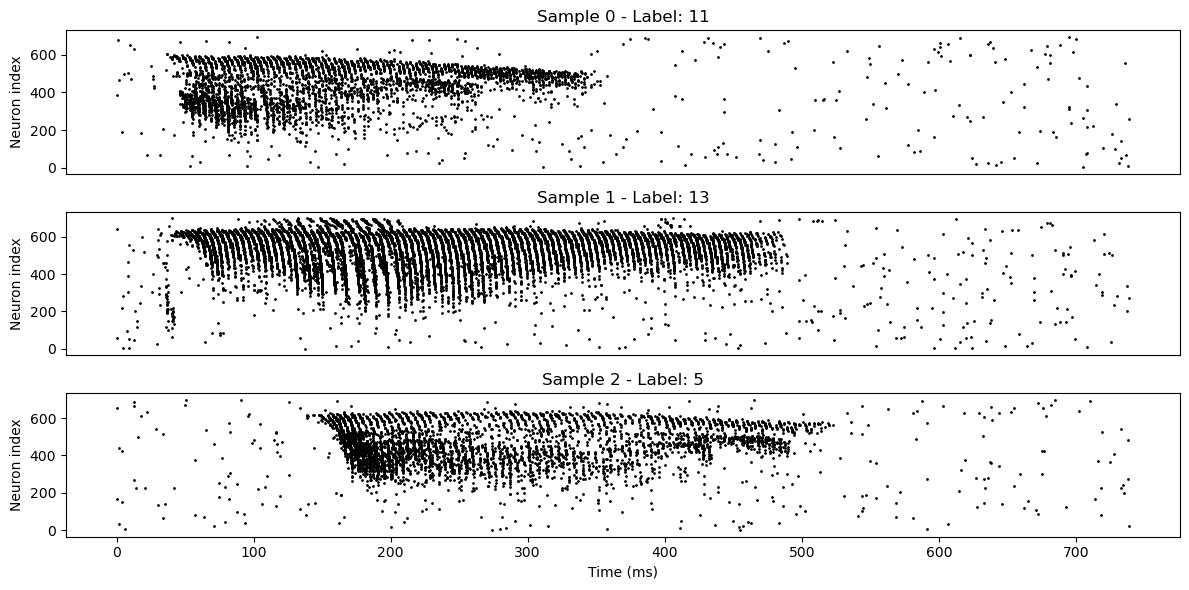

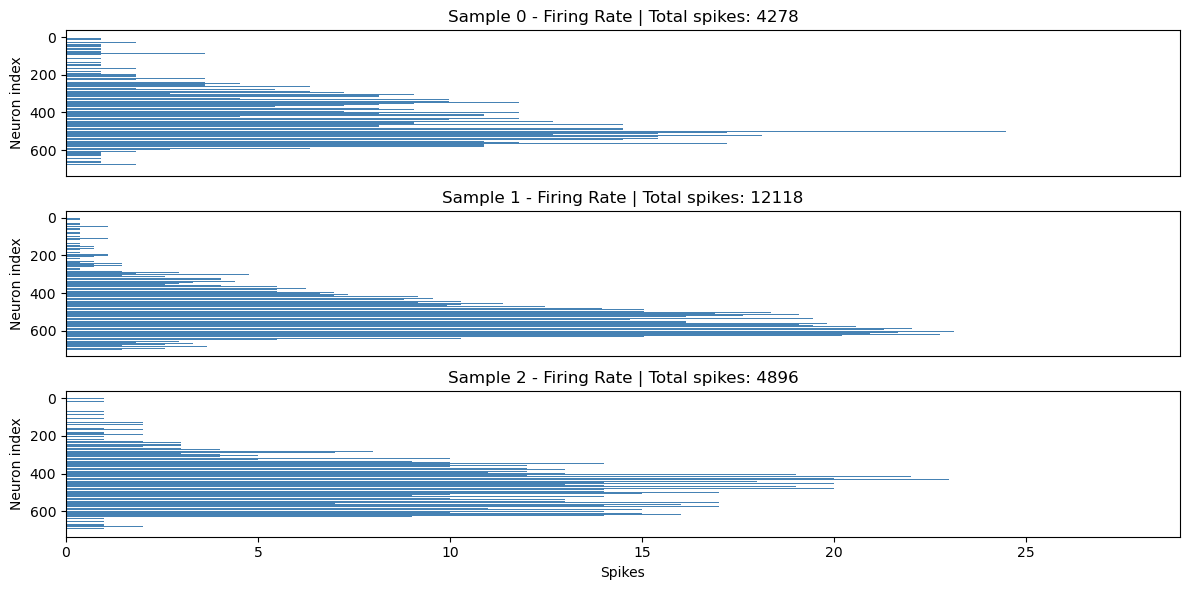

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from utils import get_shd_dataset

cache_dir = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset"
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

base_path = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset/shd"
train_path = os.path.join(base_path, "shd_train.h5")
train_file = h5py.File(train_path, "r")
test_path = os.path.join(base_path, "shd_test.h5")
test_file = h5py.File(test_path, "r")

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

n_neurons = 700
max_time = 1.4  
T = 1000     
time_resolution = 1.0
n_time_bins = int(T / time_resolution)

print("x_train['times'] shape:", x_train["times"].shape)
print("x_train['units'] shape:", x_train["units"].shape)
print("y_train shape:", y_train.shape)

print("x_test['times'] shape:", x_test["times"].shape)
print("x_test['units'] shape:", x_test["units"].shape)
print("y_test shape:", y_test.shape)

# ========== Dense spike train construction ==========
n_samples = 3
spike_trains = []
labels = []

for i in range(n_samples):
    times = x_train["times"][i] * 1000.0
    units = x_train["units"][i]
    label = y_train[i]
    
    spike_train = np.zeros((n_neurons, n_time_bins), dtype=int)
    for t, u in zip(times, units):
        t_idx = int(t / time_resolution)
        if 0 <= u < n_neurons and t_idx < n_time_bins:
            spike_train[u, t_idx] = 1

    spike_trains.append(spike_train)
    labels.append(label)

# ========== Raster Plot ==========
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(n_samples, 1)

for i, spike_train in enumerate(spike_trains):
    ax = plt.subplot(gs[i])
    for neuron_idx in range(spike_train.shape[0]):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx, s=1, color='black')
    ax.set_ylabel("Neuron index")
    ax.set_title(f"Sample {i} - Label: {labels[i]}")
    if i == n_samples - 1:
        ax.set_xlabel("Time (ms)")
    else:
        ax.set_xticks([])

plt.tight_layout()
plt.show()

# ========== Firing Rate visualization ==========
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(n_samples, 1)

for i, spike_train in enumerate(spike_trains):
    ax = plt.subplot(gs[i])
    fr = spike_train.sum(axis=1)
    ax.barh(np.arange(len(fr)), fr, color='steelblue')
    ax.set_title(f"Sample {i} - Firing Rate | Total spikes: {fr.sum()}")
    ax.set_xlim([0, fr.max() + 5])
    ax.invert_yaxis()
    ax.set_ylabel("Neuron index")
    if i == n_samples - 1:
        ax.set_xlabel("Spikes")
    else:
        ax.set_xticks([])

plt.tight_layout()
plt.show()


## Split Dataset and Save as .mat

In [ ]:
cache_dir = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset"
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

base_path = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset/shd"
train_path = os.path.join(base_path, "shd_train.h5")
train_file = h5py.File(train_path, "r")
test_path = os.path.join(base_path, "shd_test.h5")
test_file = h5py.File(test_path, "r")

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']


batch_size = 256
nb_steps = 100
nb_units = 700
max_time = 1.4

def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    labels_ = np.array(y, dtype=np.int32)
    number_of_batches = len(labels_) // batch_size
    sample_index = np.arange(len(labels_))
    firing_times = X['times']
    units_fired = X['units']
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        dense_batch = np.zeros((batch_size, nb_units, nb_steps), dtype=np.uint8)
        y_batch = []

        for bc, idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            times[times >= nb_steps] = nb_steps - 1 
            dense_batch[bc, units, times] = 1
            y_batch.append(labels_[idx])

        yield dense_batch, np.array(y_batch, dtype=np.uint8)
        counter += 1

def collect_all(X_h5, Y_h5):
    X_all = []
    Y_all = []
    for x_batch, y_batch in sparse_data_generator_from_hdf5_spikes(
            X_h5, Y_h5, batch_size, nb_steps, nb_units, max_time, shuffle=False):
        X_all.append(x_batch)
        Y_all.append(y_batch)
    X_all = np.concatenate(X_all, axis=0)
    Y_all = np.concatenate(Y_all, axis=0)
    return X_all, Y_all

X_train_all, Y_train_all = collect_all(x_train, y_train)
X_test_all, Y_test_all = collect_all(x_test, y_test)

X_all = np.concatenate([X_train_all, X_test_all], axis=0)
Y_all = np.concatenate([Y_train_all, Y_test_all], axis=0)

save_path = "D:/forStudy/IRP/IRP_Neuro_SNN/spikedata3.mat"
io.savemat(save_path, {'X': X_all, 'Y': Y_all})

print(f"Saved to: {save_path}")
print(f"X shape: {X_all.shape}, Y shape: {Y_all.shape}")

Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_train.h5
Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_test.h5
Saved to: D:/forStudy/IRP/IRP_Neuro_SNN/spikedata3.mat
X shape: (9984, 700, 100), Y shape: (9984,)


X shape: (9984, 700, 100) Y shape: (9984,)

--- 从生成器中取一个 batch 来看看 ---
生成器产出的 x_batch 形状: (4, 700, 100) y_batch: [ 6 13 17  2]


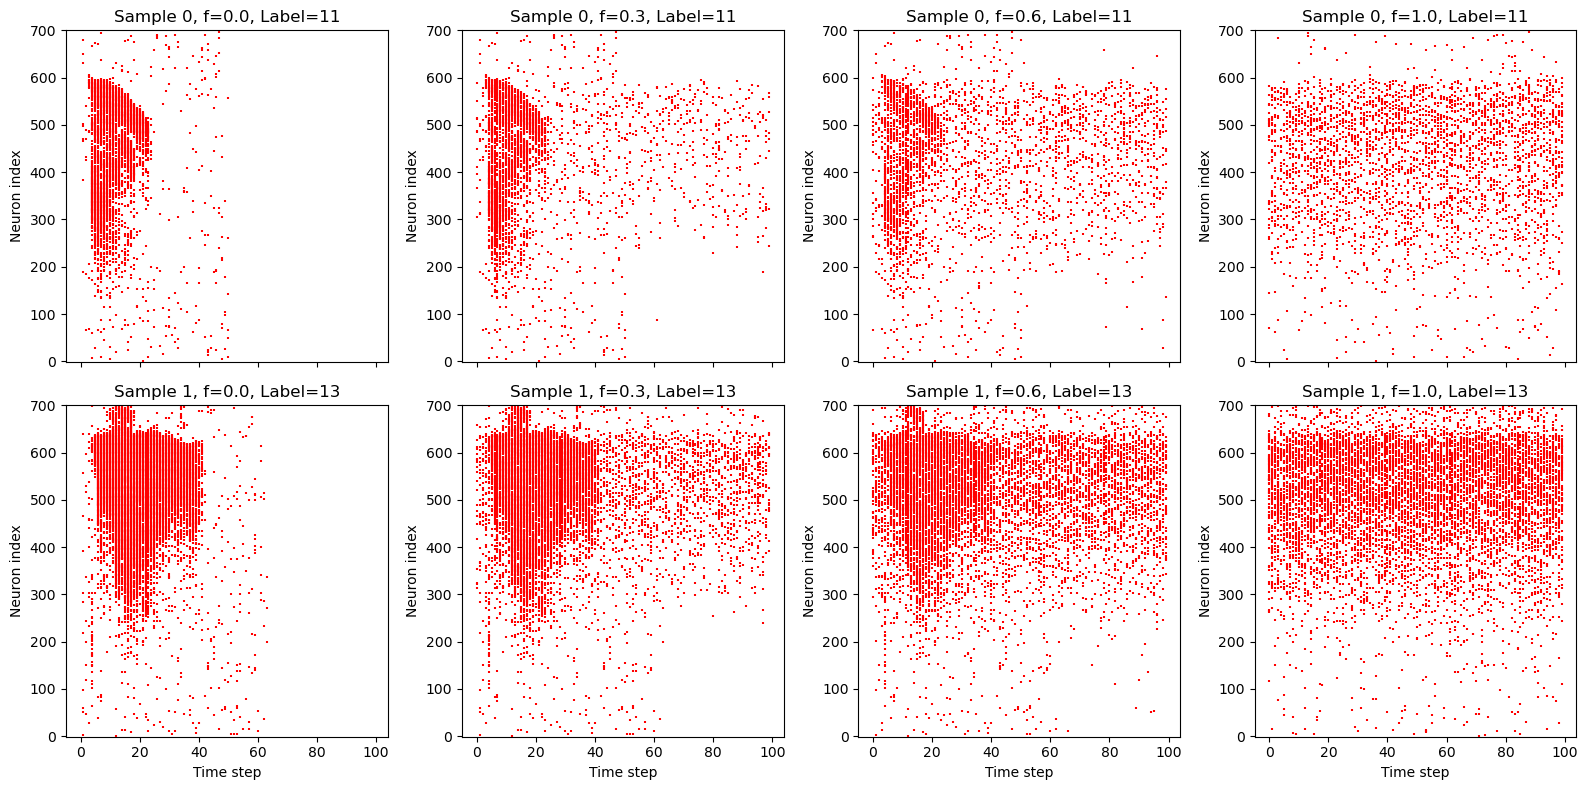

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

mat_path = "D:/forStudy/IRP/IRP_Neuro_SNN/spikedata3.mat"
data = loadmat(mat_path)
X = data["X"]  # shape (N, 700, 100)
Y = data["Y"].flatten()  # shape (N,)

N, n_neurons, T = X.shape
print("X shape:", X.shape, "Y shape:", Y.shape)

def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=50):

    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        if len(spike_times) == 0:
            continue

        num_to_jitter = int(len(spike_times) * f)
        if num_to_jitter < 1:
            continue

        chosen_times = np.random.choice(spike_times, size=num_to_jitter, replace=False)
        new_train[neuron_idx, chosen_times] = 0

        attempts = 0
        inserted = 0
        while inserted < num_to_jitter and attempts < max_attempts * num_to_jitter:
            attempts += 1
            new_t = np.random.randint(0, T)
            if new_train[neuron_idx, new_t] == 0:
                new_train[neuron_idx, new_t] = 1
                inserted += 1

    return new_train

def data_generator_with_randomization(X, Y, batch_size=4, f=0.5, shuffle=True):
    """
    generator: generater for (x_batch, y_batch) with partial randomization
      - X.shape = (N, n_neurons, T)
      - Y.shape = (N,)
    do partial randomization when generating batches rather than all data
    """
    N = len(Y)
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = N // batch_size
    for b in range(num_batches):
        batch_idx = indices[b * batch_size : (b + 1) * batch_size]

        x_batch = np.zeros((batch_size, X.shape[1], X.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)

        for i, idx in enumerate(batch_idx):
            x_randomized = partial_randomize_spike_train(X[idx], f=f)
            x_batch[i] = x_randomized
            y_batch[i] = Y[idx]

        yield x_batch, y_batch

print("\n--- getting a batch from generator ---")
gen = data_generator_with_randomization(X, Y, batch_size=4, f=0.3, shuffle=True)
x_batch, y_batch = next(gen)
print("x_batch:", x_batch.shape, "y_batch:", y_batch)

# 3) visualization: for the same sample, test the effect of different f
sample_indexes = [0, 1]
f_values = [0.0, 0.3, 0.6, 1.0]

fig, axes = plt.subplots(len(sample_indexes), len(f_values), figsize=(16, 8), sharex=True)
if len(sample_indexes) == 1:
    axes = [axes]

for i, sample_idx in enumerate(sample_indexes):
    label = Y[sample_idx] 
    
    for j, f_val in enumerate(f_values):
        randomized_train = partial_randomize_spike_train(X[sample_idx], f=f_val)
        
        ax = axes[i][j] if len(sample_indexes)>1 else axes[j]

        for neuron_idx in range(randomized_train.shape[0]):
            spike_times = np.where(randomized_train[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=2, marker='|', color='red')

        ax.set_title(f"Sample {sample_idx}, f={f_val}, Label={label}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim(-1, randomized_train.shape[0])
        if i == len(sample_indexes) - 1:
            ax.set_xlabel("Time step")

plt.tight_layout()
plt.show()


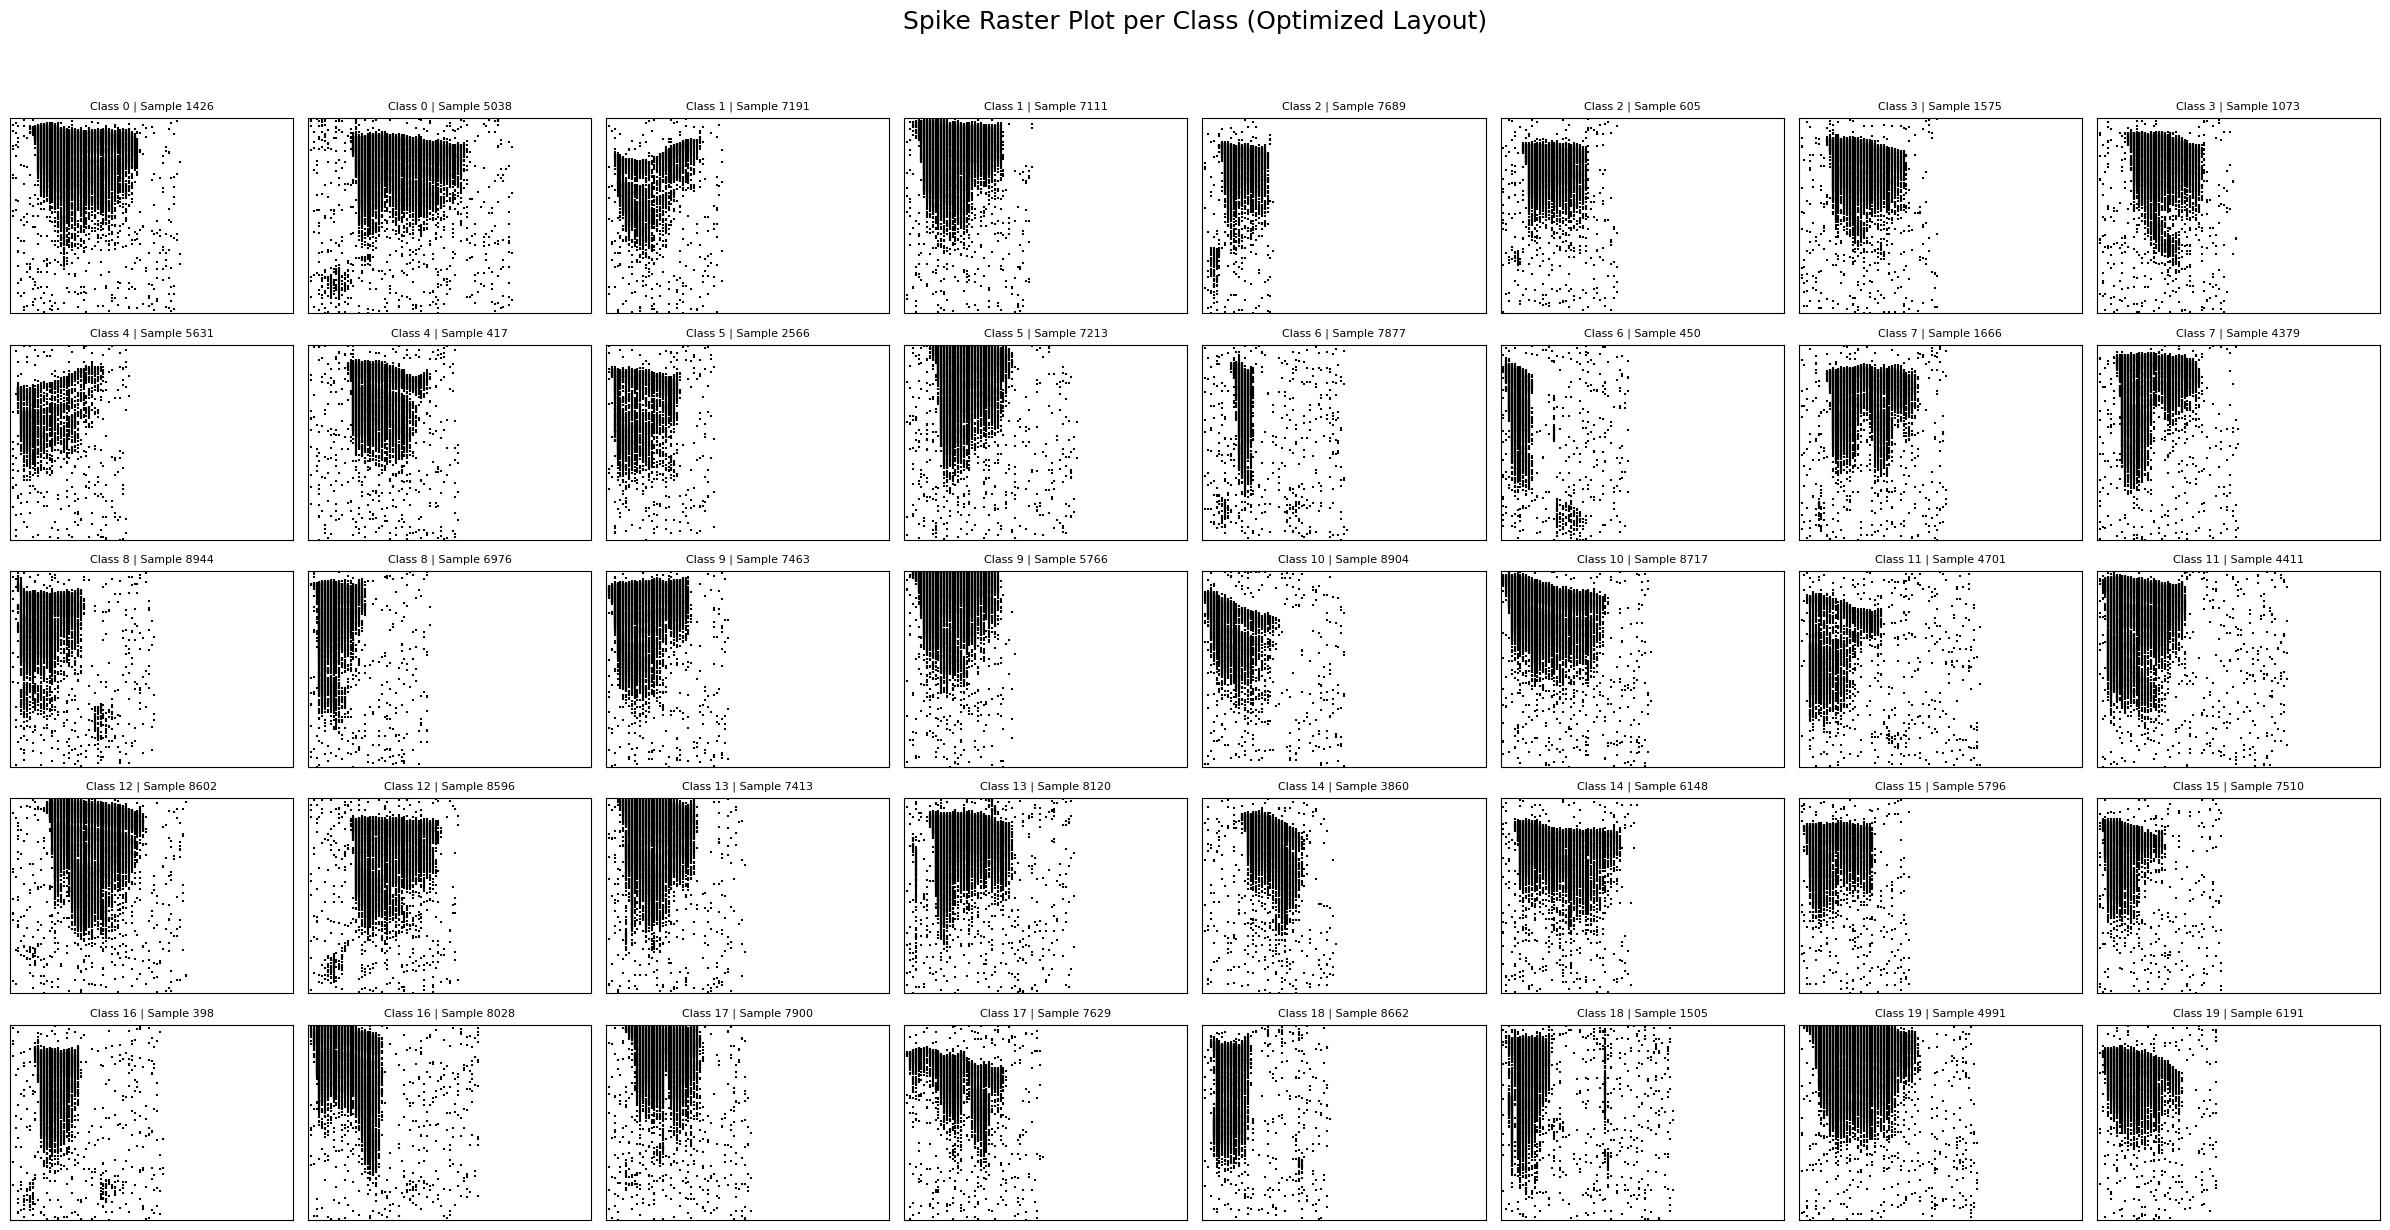

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import math

data = io.loadmat('spikedata3.mat')
X = data['X']  # shape = (N, num_neurons, T)
Y = data['Y'].ravel()

N, num_neurons, T = X.shape
unique_labels = np.unique(Y)
num_classes = len(unique_labels)

num_samples_per_class = 2
total_plots = num_classes * num_samples_per_class

ncols = 8
nrows = math.ceil(total_plots / ncols)

np.random.seed(42)
selected_samples = []
for cls in unique_labels:
    cls_indices = np.where(Y == cls)[0]
    selected = np.random.choice(cls_indices, size=num_samples_per_class, replace=False)
    selected_samples.extend([(int(cls), idx) for idx in selected])

# Visualization
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2.5*nrows), sharex=True, sharey=True)
axes = axes.flatten()
fig.suptitle("Spike Raster Plot per Class (Optimized Layout)", fontsize=18)

for i, (cls, sample_idx) in enumerate(selected_samples):
    ax = axes[i]
    spike_mat = X[sample_idx, :, :]
    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                   s=1.5, marker='|', color='black')

    ax.set_title(f"Class {cls} | Sample {sample_idx}", fontsize=8)
    ax.set_xlim([0, T])
    ax.set_ylim([0, num_neurons])
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(len(selected_samples), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Begin Here to Train

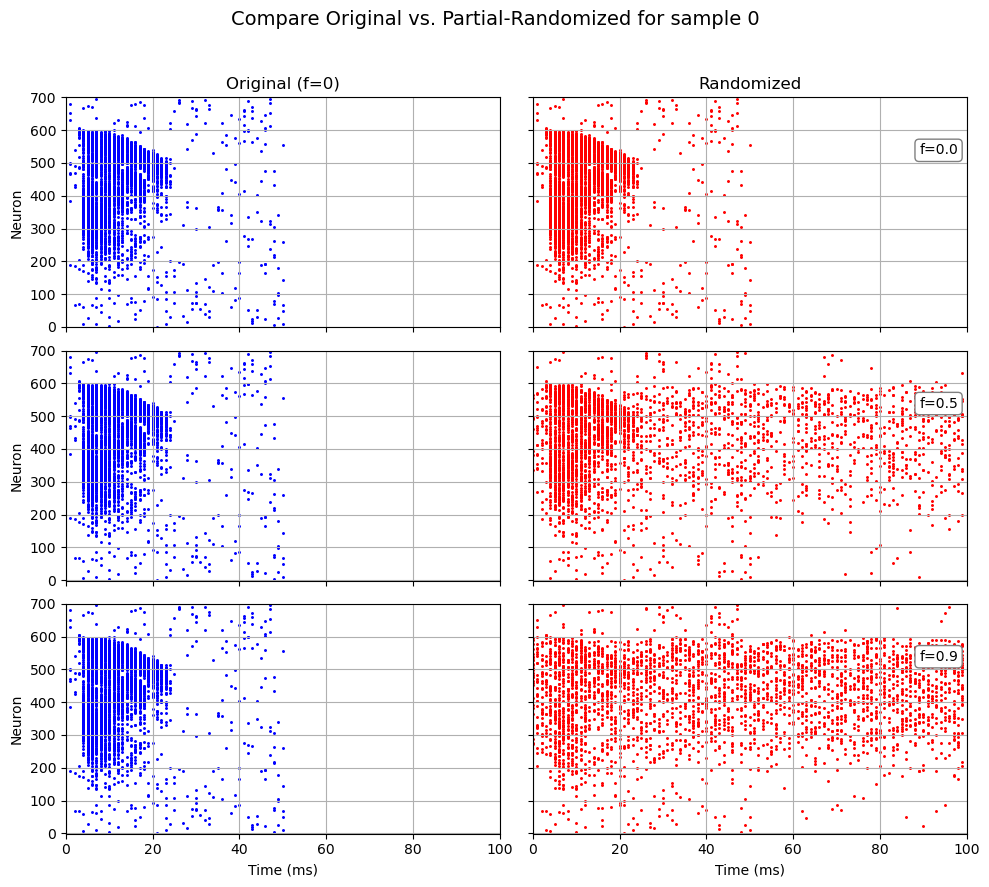

Using data index range = [0, 5990), total 5990 samples
batch_size=2
num_time_points=100
num_batches=2995
RAM usage per batch ~ 0.0010 GB
Got a batch: x_batch.shape=(2, 700, 100), y_batch=[1 0]


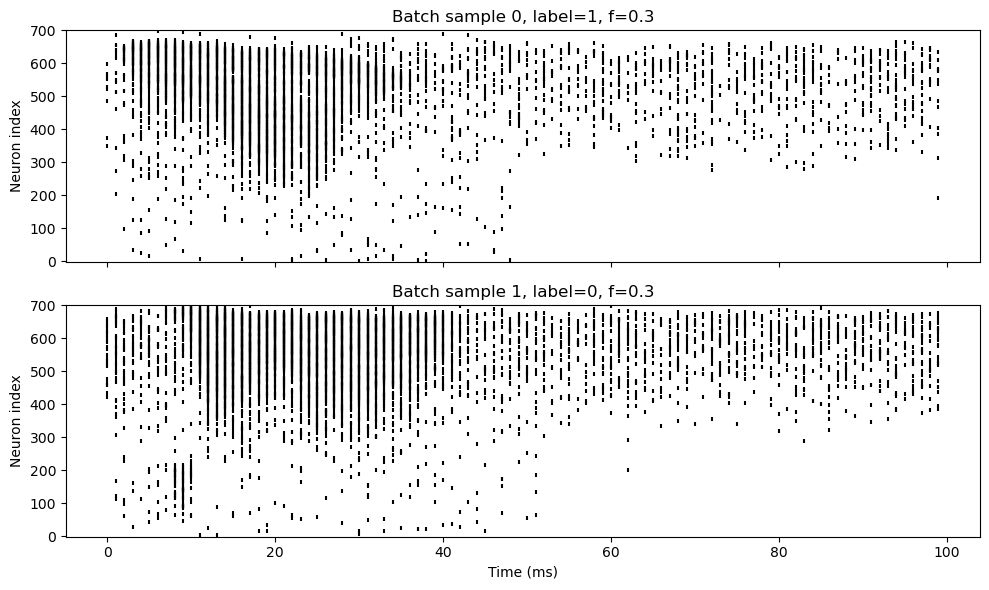

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=50):
    """
    Do partial randomization for a single spike train:
      1) randomly choose f% of spikes to set to 0
      2) insert the same number of random spikes at other time points
    returns a new spike train with the same shape as the original one.
    """
    if f == 0:
        # 如果 f=0，直接返回原始 spike_train
        return spike_train
        
    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        if len(spike_times) == 0:
            continue
        num_to_jitter = int(len(spike_times) * f)
        if num_to_jitter < 1:
            continue
        chosen_times = np.random.choice(spike_times, size=num_to_jitter, replace=False)
        new_train[neuron_idx, chosen_times] = 0
        attempts = 0
        inserted = 0
        while inserted < num_to_jitter and attempts < max_attempts * num_to_jitter:
            attempts += 1
            new_t = np.random.randint(0, T)
            if new_train[neuron_idx, new_t] == 0:
                new_train[neuron_idx, new_t] = 1
                inserted += 1

    return new_train
    
def num_batches_if(time_fractions, batch_size=32, max_num_batches=None):
    """
    return how many batches can be generated in the given time_fractions
    """
    f_start, f_end = time_fractions
    N = X.shape[0]
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    sub_len = end_idx - start_idx
    n_batches = sub_len // batch_size
    if max_num_batches is not None:
        n_batches = min(n_batches, max_num_batches)
    return n_batches

def batched_data(time_fractions, X, Y, batch_size=4, f=0.5,
                 verbose=False, shuffle=True, max_num_batches=None,
                 max_attempts=50):
    """
    for (x_batch, y_batch) in batched_data(...):
        # x_batch.shape = (batch_size, n_neurons, T)
        # y_batch.shape = (batch_size,)
    """
    N = len(Y)
    f_start, f_end = time_fractions
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    subX = X[start_idx:end_idx]  # [sub_len, n_neurons, T]
    subY = Y[start_idx:end_idx]  # [sub_len]
    sub_len = len(subY)

    indices = np.arange(sub_len)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = sub_len // batch_size
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    num_neurons = X.shape[1]
    num_time_points = X.shape[2]

    if verbose:
        print(f"Using data index range = [{start_idx}, {end_idx}), total {sub_len} samples")
        print(f"{batch_size=}")
        print(f"{num_time_points=}")
        print(f"{num_batches=}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024)**3:.4f} GB")

    for b in range(num_batches):
        batch_idx = indices[b*batch_size : (b+1)*batch_size]
        x_batch = np.zeros((batch_size, subX.shape[1], subX.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)
        for i, sidx in enumerate(batch_idx):
            x_random = partial_randomize_spike_train(subX[sidx], f=f, max_attempts=max_attempts)
            x_batch[i] = x_random
            y_batch[i] = subY[sidx]
        yield x_batch, y_batch

# Load SHD Dataset
from scipy.io import loadmat
data = loadmat("shd_whole.mat")
X = data["X"]
Y = data["Y"].ravel()
num_neurons = X.shape[1]
total_samples = X.shape[0]        

training_range   = (0, 0.6)   
validation_range = (0.6, 0.75)
testing_range    = (0.75, 0.9)

def show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.3, 0.9]):
    """
    Do partial randomization for the same sample with different f values.
    """
    original_st = X[sample_idx]  # shape = (n_neurons, T)
    fig, axes = plt.subplots(len(f_values), 2, figsize=(10, 3 * len(f_values)), sharex=True, sharey=True)
    fig.suptitle(f"Compare Original vs. Partial-Randomized for sample {sample_idx}", fontsize=14)

    for row_i, f_ in enumerate(f_values):
        # Left: Original
        ax_left = axes[row_i, 0]
        for neuron_idx in range(original_st.shape[0]):
            spike_times = np.where(original_st[neuron_idx] == 1)[0]
            ax_left.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                            s=5, color='b', marker='.')
        if row_i == 0:
            ax_left.set_title("Original (f=0)")
        ax_left.set_ylabel('Neuron')
        ax_left.grid(True)

        # Right: Partial Randomized
        x_rand = partial_randomize_spike_train(original_st, f=f_)
        ax_right = axes[row_i, 1]
        for neuron_idx in range(x_rand.shape[0]):
            spike_times = np.where(x_rand[neuron_idx] == 1)[0]
            ax_right.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                             s=5, color='r', marker='.')
        if row_i == 0:
            ax_right.set_title("Randomized")
        ax_right.text(0.98, 0.8, f"f={f_:.1f}", transform=ax_right.transAxes,
                      ha='right', va='top', fontsize=10,
                      bbox=dict(boxstyle="round", fc="white", ec="gray"))
        ax_right.grid(True)

        for ax in (ax_left, ax_right):
            ax.set_ylim([-1, original_st.shape[0]])
            ax.set_xlim([0, original_st.shape[1]])

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def demo_batch_visualization(X, Y, time_fractions=(0, 0.2), batch_size=2, f=0.5):
    """
    Use batched_data() to get one batch and do visualization.
    """
    gen = batched_data(time_fractions, X, Y, batch_size=batch_size, f=f, shuffle=True, verbose=True)
    x_batch, y_batch = next(gen)
    print(f"Got a batch: x_batch.shape={x_batch.shape}, y_batch={y_batch}")

    fig, axes = plt.subplots(batch_size, 1, figsize=(10, 3*batch_size), sharex=True, sharey=True)
    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        spike_mat = x_batch[i]  # shape=(n_neurons, T)
        for neuron_idx in range(spike_mat.shape[0]):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=5, marker='|', color='black')
        ax.set_title(f"Batch sample {i}, label={y_batch[i]}, f={f}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim([-1, spike_mat.shape[0]])
    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()


show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.5, 0.9])
demo_batch_visualization(X, Y, time_fractions=training_range, batch_size=2, f=0.3)

## Build the Spiking Neural Network Model (SNN)

In [2]:
import torch
import torch.nn as nn
import numpy as np


class SurrGradSpike(torch.autograd.Function):
    scale = 100.0 

    @staticmethod
    def forward(ctx, input):
        """
        在 forward 中做 Heaviside(step) 函数
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        surrogate gradient: d/dx of H(x) ≈ 1/(scale*|x|+1)^2
        """
        (inp,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale*torch.abs(inp) + 1.0)**2
        return grad

spike_fn = SurrGradSpike.apply

# 1) hidden Layer w1 & v1 + (syn, mem) Update
# 2) readout Layer w2 + flt, out Update
# 3) Finally return out_rec, [mem_rec, spk_rec]
class TutorialSNN(nn.Module):
    def __init__(self,nb_inputs=700,nb_hidden=200,nb_outputs=20,time_step=1e-3,
                 tau_mem=10e-3,tau_syn=5e-3,weight_scale=0.2,device='cpu'):
        """
        w1, w2, v1 都用 normal_(..., std=weight_scale/sqrt(...))
        alpha, beta = exp(-dt/tau_syn), exp(-dt/tau_mem)
        """
        super().__init__()

        self.nb_inputs  = nb_inputs
        self.nb_hidden  = nb_hidden
        self.nb_outputs = nb_outputs
        self.time_step  = time_step
        self.tau_mem    = tau_mem
        self.tau_syn    = tau_syn
        self.device_str = device

        # w1 => (n_in, n_hidden)
        self.w1 = nn.Parameter(torch.empty((nb_inputs, nb_hidden), dtype=torch.float))
        # v1 => (n_hidden, n_hidden)
        self.v1 = nn.Parameter(torch.empty((nb_hidden, nb_hidden), dtype=torch.float))
        # w2 => (n_hidden, n_outputs)
        self.w2 = nn.Parameter(torch.empty((nb_hidden, nb_outputs), dtype=torch.float))

        # init
        torch.nn.init.normal_(self.w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
        torch.nn.init.normal_(self.w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
        torch.nn.init.normal_(self.v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

        # alpha, beta
        self.alpha = float(np.exp(-time_step / tau_syn))
        self.beta  = float(np.exp(-time_step / tau_mem))

    def forward(self, inputs, dtype=torch.float32):
        """
        inputs shape = (batch_size, nb_steps, nb_inputs)
        h1_from_input = einsum('abc,cd->abd',(inputs, w1))
        Finally return out_rec, [mem_rec, spk_rec]
        """
        if inputs.dim() == 3:
            inputs = inputs.permute(0, 2, 1)  # (B, T, input_size)

        device = torch.device(self.device_str if torch.cuda.is_available() else 'cpu')
        inputs = inputs.to(device=device, dtype=dtype)
        batch_size, nb_steps, _ = inputs.shape 

        # hidden states
        syn = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)

        mem_rec = []
        spk_rec = []

        # 1) Calculate input->hidden
        # inputs shape => (B,T,n_in) w1 => (n_in,n_hidden) => result => (B,T,n_hidden)
        h1_from_input = torch.einsum("abc,cd->abd", (inputs, self.w1.to(inputs.device)))

        # 2) nb_steps
        for t in range(nb_steps):
            # recurrent: out =>(B,n_hidden), v1=>(n_hidden,n_hidden) => shape(B,n_hidden)
            rec_input = torch.einsum("ab,bc->ac", (out, self.v1.to(inputs.device)))
            h1 = h1_from_input[:, t, :] + rec_input

            # mem-1 => spike
            mthr = mem - 1.0
            out_new = spike_fn(mthr)
            rst = out_new.detach()  # not backprop

            # new_syn= alpha*syn + h1
            # new_mem= (beta*mem + syn)*(1.0 - rst)
            new_syn = self.alpha*syn + h1
            new_mem = (self.beta*mem + syn)*(1.0 - rst)
            mem_rec.append(mem)
            spk_rec.append(out_new)
            mem = new_mem
            syn = new_syn
            out = out_new

        mem_rec = torch.stack(mem_rec, dim=1)
        spk_rec = torch.stack(spk_rec, dim=1)

        # 3) readout layer
        #  spk_rec => shape(B, nb_steps, n_hidden)
        h2 = torch.einsum("abc,cd->abd", (spk_rec, self.w2.to(inputs.device)))

        # flt, out =>(B, nb_outputs)
        flt = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_read = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_rec = [out_read]

        for t in range(nb_steps):
            new_flt = self.alpha*flt + h2[:, t, :]
            new_out = self.beta*out_read + flt
            flt = new_flt
            out_read = new_out
            out_rec.append(out_read)

        # =>(nb_steps+1, B, nb_outputs)->(B, nb_steps+1, nb_outputs)
        out_rec = torch.stack(out_rec, dim=1)
        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs


In [6]:
import torch
import torch.nn.functional as F
import numpy as np

num_classes = 20

def evaluate_network(net, time_fractions, batch_size=64, f=0.0, device='cpu'):
    """
    Evaluate: max-over-time + NLL loss + null baseline
    """
    net.eval()
    losses = []
    null_losses = []
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y,batch_size=batch_size,f=f, shuffle=False,max_num_batches=2)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, other_recs = net(x_t)
            m, _ = torch.max(out_rec, dim=1)  # => (B, nb_outputs)
            log_probs = log_softmax_fn(m)

            y_t = y_t.to(log_probs.device)
            loss_val = loss_fn(log_probs, y_t)
            losses.append(loss_val.item())

            # null_loss: log_softmax(zeros)
            zero_logits = torch.zeros_like(m)
            null_lp = log_softmax_fn(zero_logits)
            null_val = loss_fn(null_lp, y_t)
            null_losses.append(null_val.item())

    avg_loss = np.mean(losses) if len(losses) else 0.
    avg_null = np.mean(null_losses) if len(null_losses) else 0.
    return avg_loss, avg_null

## 对每个 batch -> run_snn-> out_rec + spk_rec 计算 cross_entropy + spike regularizer 优化器用 Adamax
def train_model(f=0.0, num_epochs=100, batch_size=64, max_num_batches=40,
                lr=2e-4, hidden_units=200, device='cuda', seed=42):
    print(f"\n=== Training model with f={f}, num_epochs={num_epochs}, seed={seed} ===")

    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    dev = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {dev}")

    net = TutorialSNN(num_neurons, hidden_units, num_classes).to(dev)

    optimizer = torch.optim.Adamax(net.parameters(), lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    best_model_state = None

    train_batches = num_batches_if(training_range,batch_size=batch_size,max_num_batches=max_num_batches)
    total_batches = num_epochs * train_batches

    from tqdm import tqdm
    with tqdm(total=total_batches) as pbar:
        for epoch in range(num_epochs):
            net.train()
            local_losses = []

            train_gen = batched_data(training_range, X, Y, batch_size=batch_size, f=f,
                                     shuffle=True, verbose=(epoch==0), max_num_batches=max_num_batches)

            for x_np, y_np in train_gen:
                x_t = torch.tensor(x_np, dtype=torch.float32, device=dev)
                y_t = torch.tensor(y_np, dtype=torch.long, device=dev)

                out_rec, other_recs = net(x_t)
                spk_rec = other_recs[1]

                m, _ = torch.max(out_rec, dim=1)
                log_probs = log_softmax_fn(m)

                l1_loss = 2e-6 * torch.sum(spk_rec)
                sum_per_neuron = torch.sum(spk_rec, dim=[0,1])  # (hidden,)
                l2_loss = 2e-6 * torch.mean(sum_per_neuron**2)

                reg_loss = l1_loss + l2_loss

                y_t = y_t.to(log_probs.device)
                loss_val = loss_fn(log_probs, y_t) + reg_loss
                local_losses.append(loss_val.item())

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                pbar.update(1)

            last_epoch_loss = np.mean(local_losses) if local_losses else 0.
            val_loss, null_val_loss = evaluate_network(net,validation_range,batch_size=64,f=f,device=dev)

            val_loss_hist.append(val_loss)
            loss_hist.append(last_epoch_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = net.state_dict()

            pbar.set_postfix(epoch=epoch,train_loss=last_epoch_loss,val_loss=val_loss,null_val=null_val_loss)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.semilogy(loss_hist, label='Train loss')
    plt.semilogy(val_loss_hist, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if best_model_state is not None:
        net.load_state_dict(best_model_state)
        print(f"Loaded best model with val_loss={best_val_loss:.4f}")

    test_loss, null_test_loss = evaluate_network(net,testing_range,batch_size=64,f=f,device=dev)
    print(f"Final Test: test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")

    return net, best_val_loss

def test_accuracy(net, time_fractions=testing_range, batch_size=64, f=0, device='cpu'):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y,batch_size=batch_size,f=f,shuffle=False,max_num_batches=40)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, _ = net(x_t, dtype=x_t.dtype)

            # max over time => (B,O)
            m, _ = torch.max(out_rec, dim=1)
            preds = torch.argmax(m, dim=1)  # shape=(B,)

            y_t = y_t.to(preds.device)
            correct += (preds == y_t).sum().item()
            total   += y_t.shape[0]

    acc = correct/total if total>0 else 0.
    return acc



### Training model for f = 0.0 ###

=== Training model with f=0.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [31:01<00:00,  3.22it/s, epoch=149, null_val=3, train_loss=0.23, val_loss=0.369] 


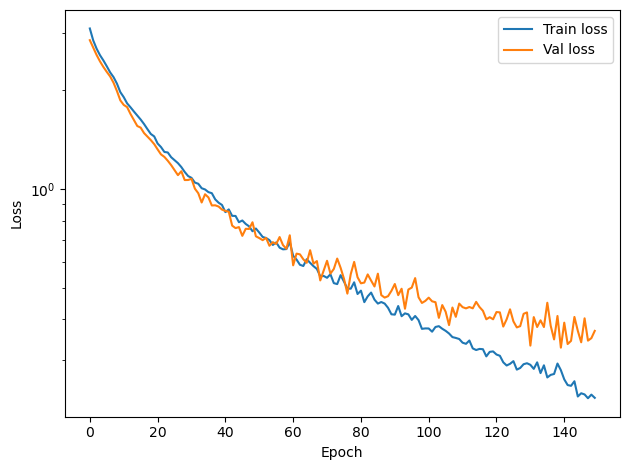

Loaded best model with val_loss=0.3276
Final Test: test_loss=0.3428, null_test_loss=2.9957
Saved model: ss3_f00.pt
f=0.0, Test Accuracy: 87.89%


In [70]:
f_values = [0.0]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"ss3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")


### Training model for f = 0.9 ###

=== Training model with f=0.9, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [3:20:14<00:00,  2.00s/it, epoch=149, null_val=3, train_loss=0.593, val_loss=0.883]  


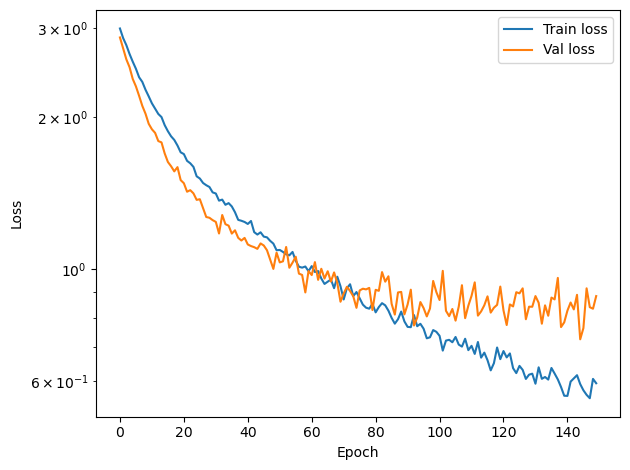

Loaded best model with val_loss=0.7249
Final Test: test_loss=0.8793, null_test_loss=2.9957
Saved model: sss3_f09.pt
f=0.9, Test Accuracy: 59.80%


In [41]:
f_values = [0.9]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"sss3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")


### Training model for f = 0.3 ###

=== Training model with f=0.3, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [1:59:18<00:00,  1.19s/it, epoch=149, null_val=3, train_loss=0.3, val_loss=0.545]   


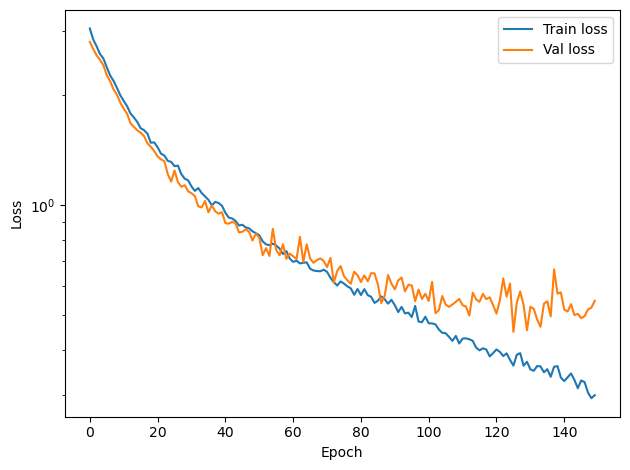

Loaded best model with val_loss=0.4480
Final Test: test_loss=0.4533, null_test_loss=2.9957
Saved model: sss3_f03.pt
f=0.3, Test Accuracy: 81.64%

### Training model for f = 0.6 ###

=== Training model with f=0.6, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [2:36:15<00:00,  1.56s/it, epoch=149, null_val=3, train_loss=0.485, val_loss=0.591]  


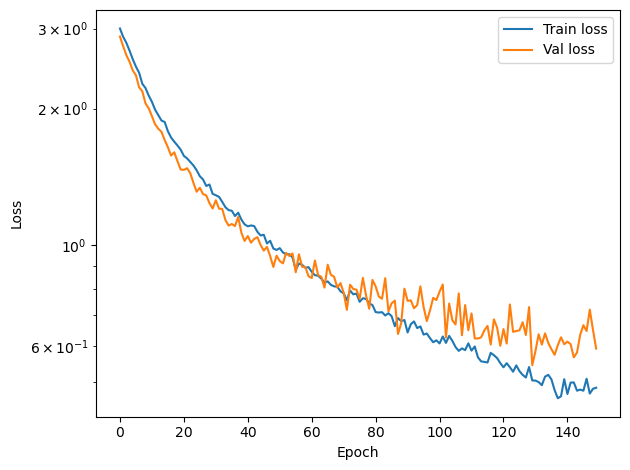

Loaded best model with val_loss=0.5437
Final Test: test_loss=0.5190, null_test_loss=2.9957
Saved model: sss3_f06.pt
f=0.6, Test Accuracy: 80.08%


In [60]:
f_values = [0.3, 0.6]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"sss3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")


### Training model for f = 0.1 ###

=== Training model with f=0.1, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [1:18:19<00:00,  1.28it/s, epoch=149, null_val=3, train_loss=0.263, val_loss=0.404]


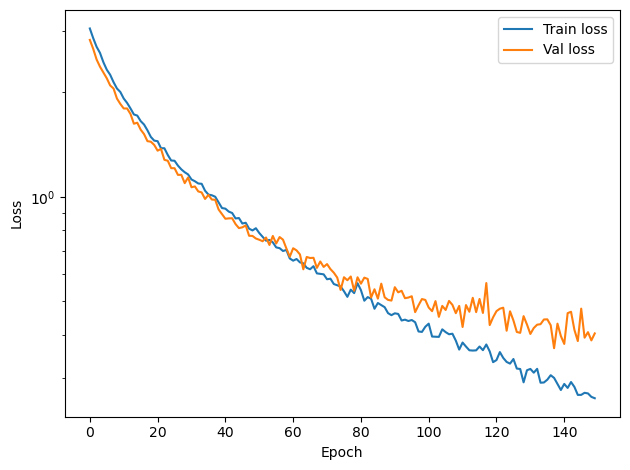

Loaded best model with val_loss=0.3661
Final Test: test_loss=0.4852, null_test_loss=2.9957
Saved model: sss3_f01.pt
f=0.1, Test Accuracy: 85.94%

### Training model for f = 0.2 ###

=== Training model with f=0.2, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [1:39:49<00:00,  1.00it/s, epoch=149, null_val=3, train_loss=0.276, val_loss=0.496]


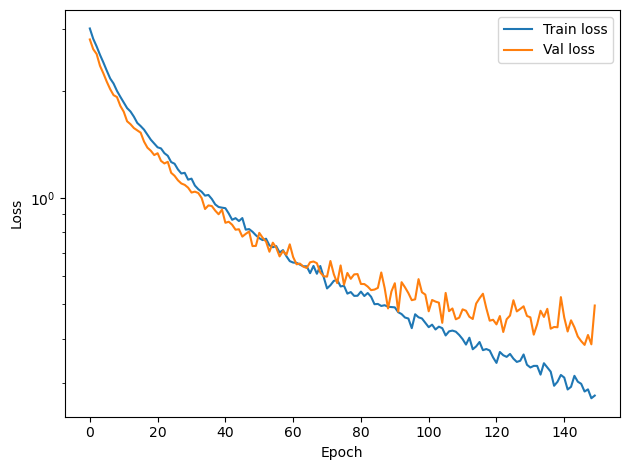

Loaded best model with val_loss=0.3843
Final Test: test_loss=0.3655, null_test_loss=2.9957
Saved model: sss3_f02.pt
f=0.2, Test Accuracy: 85.55%

### Training model for f = 0.4 ###

=== Training model with f=0.4, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [2:10:02<00:00,  1.30s/it, epoch=149, null_val=3, train_loss=0.333, val_loss=0.409] 


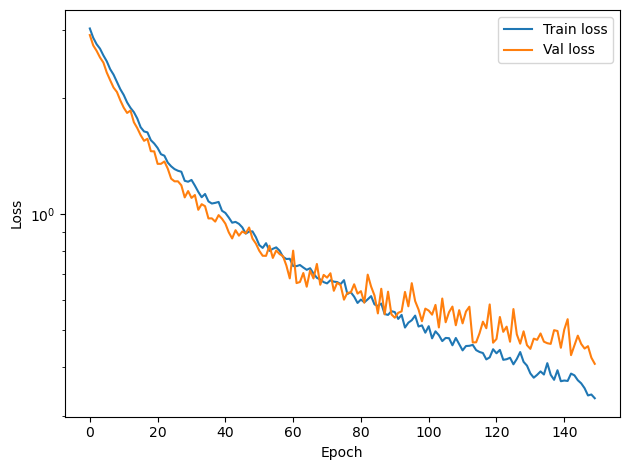

Loaded best model with val_loss=0.4088
Final Test: test_loss=0.5496, null_test_loss=2.9957
Saved model: sss3_f04.pt
f=0.4, Test Accuracy: 79.30%

### Training model for f = 0.5 ###

=== Training model with f=0.5, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [2:26:56<00:00,  1.47s/it, epoch=149, null_val=3, train_loss=0.41, val_loss=0.53]    


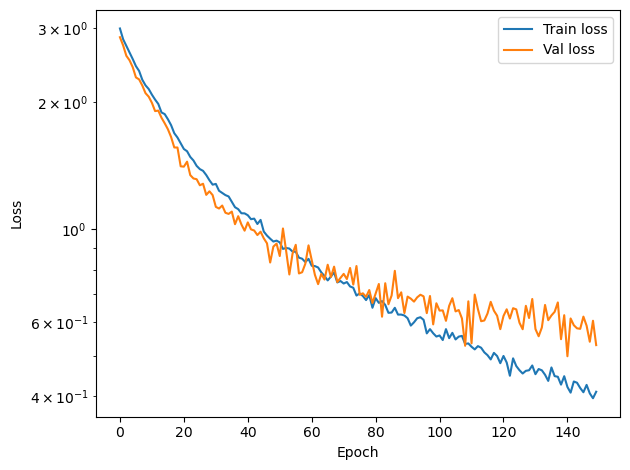

Loaded best model with val_loss=0.4984
Final Test: test_loss=0.4696, null_test_loss=2.9957
Saved model: sss3_f05.pt
f=0.5, Test Accuracy: 77.73%

### Training model for f = 0.7 ###

=== Training model with f=0.7, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [2:50:26<00:00,  1.70s/it, epoch=149, null_val=3, train_loss=0.532, val_loss=0.619]  


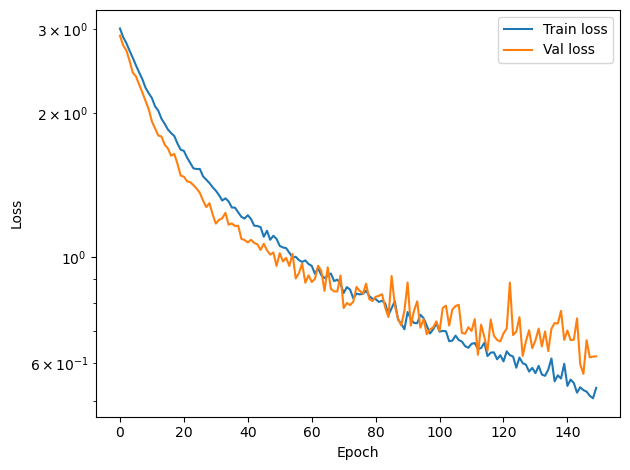

Loaded best model with val_loss=0.5689
Final Test: test_loss=0.5841, null_test_loss=2.9957
Saved model: sss3_f07.pt
f=0.7, Test Accuracy: 76.56%

### Training model for f = 0.8 ###

=== Training model with f=0.8, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [3:05:56<00:00,  1.86s/it, epoch=149, null_val=3, train_loss=0.572, val_loss=0.84]   


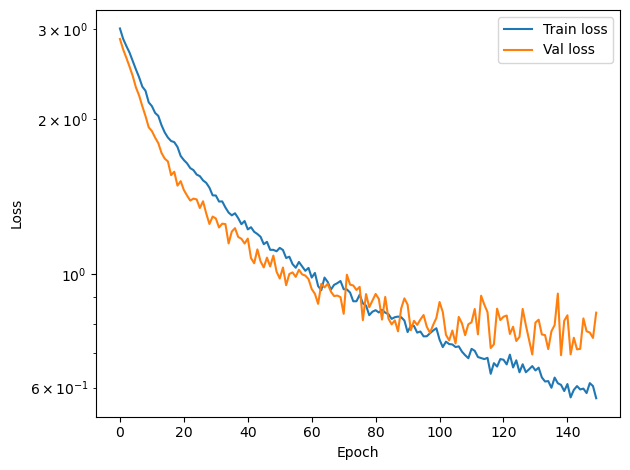

Loaded best model with val_loss=0.6941
Final Test: test_loss=0.6134, null_test_loss=2.9957
Saved model: sss3_f08.pt
f=0.8, Test Accuracy: 77.73%

### Training model for f = 1.0 ###

=== Training model with f=1.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [4:19:26<00:00,  2.59s/it, epoch=149, null_val=3, train_loss=0.569, val_loss=0.583]  


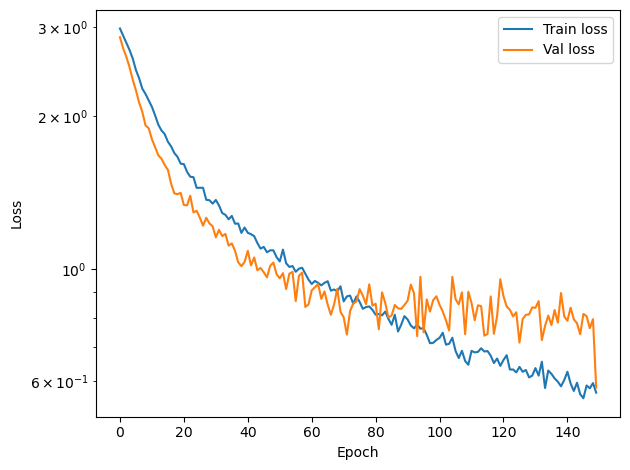

Loaded best model with val_loss=0.5825
Final Test: test_loss=0.8809, null_test_loss=2.9957
Saved model: sss3_f10.pt
f=1.0, Test Accuracy: 76.95%


In [62]:
f_values = [0.1,0.2,0.4,0.5,0.7,0.8,1.0]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"sss3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")


### Training model for f = 1.0 ###

=== Training model with f=1.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5990), total 5990 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0334 GB


100%|██████████| 6000/6000 [3:17:40<00:00,  1.98s/it, epoch=149, null_val=3, train_loss=0.569, val_loss=0.583]  


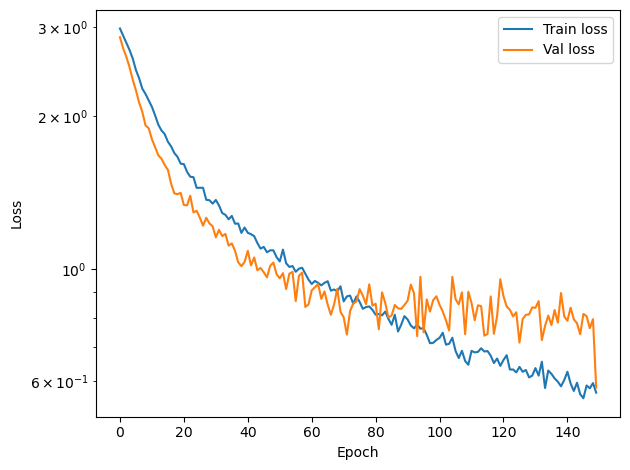

Loaded best model with val_loss=0.5825
Final Test: test_loss=0.8809, null_test_loss=2.9957
Saved model: s23_f10.pt
f=1.0, Test Accuracy: 76.95%


In [76]:
f_values = [1.0]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"s23_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")

## Evaluation

Using device: cuda

=== Loading model code_tidy/model_step3_SHD/sss3_f00.pt and testing (f=0.0) ===
f=0.0, Mean Acc=74.22%, Std=0.00% (over 5 runs)

=== Loading model code_tidy/model_step3_SHD/sss3_f01.pt and testing (f=0.1) ===
f=0.1, Mean Acc=75.67%, Std=0.35% (over 5 runs)

=== Loading model code_tidy/model_step3_SHD/sss3_f02.pt and testing (f=0.2) ===
f=0.2, Mean Acc=74.03%, Std=0.64% (over 5 runs)

=== Loading model code_tidy/model_step3_SHD/sss3_f03.pt and testing (f=0.3) ===
f=0.3, Mean Acc=72.30%, Std=0.30% (over 5 runs)

=== Loading model code_tidy/model_step3_SHD/sss3_f04.pt and testing (f=0.4) ===
f=0.4, Mean Acc=71.86%, Std=0.83% (over 5 runs)

=== Loading model code_tidy/model_step3_SHD/sss3_f05.pt and testing (f=0.5) ===
f=0.5, Mean Acc=69.55%, Std=0.76% (over 5 runs)

=== Loading model code_tidy/model_step3_SHD/sss3_f06.pt and testing (f=0.6) ===
f=0.6, Mean Acc=69.66%, Std=0.35% (over 5 runs)

=== Loading model code_tidy/model_step3_SHD/sss3_f07.pt and testing (f=0.7) =

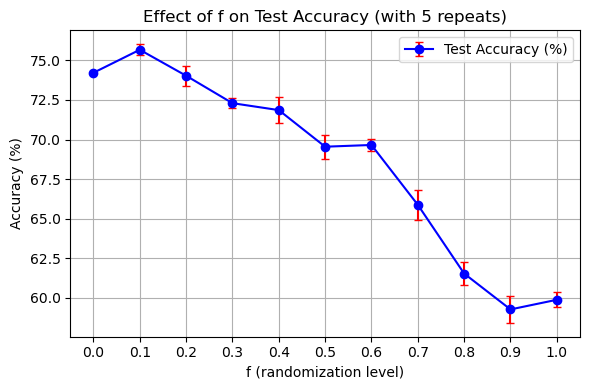

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

# ========== 1. 加载数据 ==========
data = io.loadmat('shd_whole.mat')
X = data['X']  # (N, num_neurons, T)
Y = data['Y'].ravel()

f_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
repeats = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========== 2. Accuracy repeat wrapper ==========
def test_accuracy_repeats(net, repeats=5, f=0.0):
    acc_list = []
    for _ in range(repeats):
        acc = test_accuracy(
            net,
            time_fractions=testing_range,
            batch_size=256,
            f=f,
            device=device
        )
        acc_list.append(acc)
    return acc_list

# ========== 3. 评估每个 f 值下模型性能 ==========
all_means = []
all_stds = []

for f in f_values:
    model_path = f"code_tidy/model_step3_SHD/sss3_f{int(f*10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing (f={f}) ===")

    net = TutorialSNN(num_neurons, 200, num_classes)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()

    acc_list = test_accuracy_repeats(net, repeats=repeats, f=f)
    mean_acc = np.mean(acc_list)
    std_acc = np.std(acc_list)

    all_means.append(mean_acc)
    all_stds.append(std_acc)

    print(f"f={f:.1f}, Mean Acc={mean_acc:.2%}, Std={std_acc:.2%} (over {repeats} runs)")

# ========== 4. 可视化 ==========
plt.figure(figsize=(6, 4))
means_pct = [m * 100 for m in all_means]
stds_pct  = [s * 100 for s in all_stds]

plt.errorbar(f_values, means_pct, yerr=stds_pct,
             fmt='-o', color='b', ecolor='r', capsize=3,
             label='Test Accuracy (%)')

plt.xlabel("f (randomization level)")
plt.ylabel("Accuracy (%)")
plt.title(f"Effect of f on Test Accuracy (with {repeats} repeats)")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
